In [1]:
ROOT = '../'

In [2]:
EMBPATH = ROOT + 'data/embeddings/'

### Binary - Commenting Dataset

In [3]:
DPATH = ROOT + 'data/safecity/binary/commenting/'

In [4]:
MPATH = ROOT + 'models/notebook6/commenting/'

### Binary - Groping Dataset

In [3]:
DPATH = ROOT + 'data/safecity/binary/groping/'

In [4]:
MPATH = ROOT + 'models/notebook6/groping/'

### Binary - Ogling Dataset

In [3]:
DPATH = ROOT + 'data/safecity/binary/ogling/'

In [4]:
MPATH = ROOT + 'models/notebook6/ogling/'

### Text Classifier

In [5]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

from torch.nn.utils import clip_grad_norm_
from torchtext import data, datasets, vocab

from sklearn.metrics import confusion_matrix

import random
import sys
import copy
from glob import glob
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
BATCH_SIZE = 128
FILTER_SIZES = [3, 4, 5]
# CLIP_GRAD_NORM = 8

In [7]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=2)

In [8]:
import re, string
import spacy

nlp = spacy.load('en_core_web_sm')
punctuation = string.punctuation
stopwords = spacy.lang.en.stop_words.STOP_WORDS

def cleanup(text):
    """
    Tokenization/text cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)
    text = re.sub(r"\'s", " \'s", text)
    text = re.sub(r"\'ve", " \'ve", text)
    text = re.sub(r"n\'t", " n\'t", text)
    text = re.sub(r"\'re", " \'re", text)
    text = re.sub(r"\'d", " \'d", text)
    text = re.sub(r"\'ll", " \'ll", text)
    text = re.sub(r",", " , ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\(", " \( ", text)
    text = re.sub(r"\)", " \) ", text)
    text = re.sub(r"\?", " \? ", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text.strip()

def tokenizer(sentence):
    sentence = cleanup(sentence) # regex cleanup  
    tokens = nlp(sentence, disable=['parser', 'tagger', 'ner']) # tokenizer
    tokens = [tok.lemma_.lower().strip() for tok in tokens if tok.lemma_ != '-PRON-'] # lemmatizer
    tokens = [tok for tok in tokens if tok not in punctuation] # punctuation removal

    if len(tokens) < FILTER_SIZES[-1]:
        tokens += ['<pad>']*(FILTER_SIZES[-1] - len(tokens))
        
    return tokens

In [9]:
text_field = data.Field(batch_first=True, lower=True, tokenize=tokenizer)
label_field = data.LabelField(dtype=torch.float)

In [10]:
fields = [('Description', text_field), ('Category', label_field)] # order must be same as cols of csv
trainset, validset, testset = data.TabularDataset.splits(
                                        path=DPATH,
                                        train='train.csv',
                                        validation='dev.csv',
                                        test='test.csv',
                                        format='csv',
                                        fields=fields,
                                        skip_header=True)

print(f'Trainset length: {len(trainset)}')
print(f'Validset length: {len(validset)}')
print(f'Testset length: {len(testset)}')

Trainset length: 7201
Validset length: 990
Testset length: 1701


In [11]:
vecs = vocab.Vectors('glove.6B.300d.txt', EMBPATH)

text_field.build_vocab(trainset, validset, testset, vectors=vecs) 
label_field.build_vocab(trainset, validset, testset)

In [12]:
trainloader, validloader, testloader = data.BucketIterator.splits(
                                  (trainset, validset, testset), 
                                  batch_sizes=[BATCH_SIZE]*3,
                                  sort_key=lambda x: len(x.Description),
                                  sort_within_batch=True, 
                                  shuffle=True, 
                                  repeat=False,
                                  device=device)

print(f"Train DL length: {len(trainloader)}")
print(f"Valid DL length: {len(validloader)}")
print(f"Test DL length: {len(testloader)}")

Train DL length: 57
Valid DL length: 8
Test DL length: 14


In [13]:
n_tokens = len(text_field.vocab)
n_classes = len(label_field.vocab)

print(f"Number of tokens: {n_tokens}")
print(f"Number of classes: {n_classes}")

Number of tokens: 8372
Number of classes: 2


`max_pool1d(tensor, kernel_size, stride=None)`: default value of `stride` is `kernel_size`
and $L \rightarrow \left\lfloor\dfrac{L - K + 2P}{K} + 1\right\rfloor$

In [14]:
class Network(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_filters, 
                 filter_sizes, output_dim, padding_idx,
                 hidden_dim, n_layers, dropout=0.4):
        super().__init__()
        
        # encoder
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim).from_pretrained(
                                        text_field.vocab.vectors, # freeze=True by default
                                        padding_idx=padding_idx)
        
        # concatenated convolutions
        self.convs = nn.ModuleList([
                                    nn.Sequential(
                                        nn.ConstantPad1d((k//2, k//2 + k%2 - 1), value=0),
                                        nn.Conv1d(embed_dim, n_filters, kernel_size=k)
                                    ) for k in filter_sizes
                                    ])

        self.k_pool = sum(filter_sizes) // len(filter_sizes)
        assert self.k_pool % 2 == 0, "Kernel size should be even for perfect max pooling"
        
        self.rnn = nn.LSTM(n_filters*len(filter_sizes), hidden_dim, n_layers,
                           dropout=dropout, batch_first=True)
        
        # use MaxPool1d as well
        
        # linear layer
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        
        # dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        ### Embeddings ###
        # input x has shape (B, S) which is batch of sentences (sentence is list of word indices)
        x = self.dropout(self.embedding(x)) 
        # encoded input x has shape (B, S, E)
        x = x.permute(0, 2, 1)
        # shape (B, E, S)
        
        ### Convolution ###
        # conved
        conved = [F.relu(conv(x)) for conv in self.convs]
        # gives list of shapes (B, N, S), where N is no of filters ("same" convolution)
        
        # pooled
        pooled = [F.max_pool1d(conv, kernel_size=self.k_pool, padding=self.k_pool//2)
                      for conv in conved]
        # gives list of shapes (B, N, S'), S' = S // k_pool + 1
        out = torch.cat(pooled, dim=1)
        # shape (B, N*|F|, S'), where |F| is the no of different filter sizes
        
        ### GRU ###
        out = out.permute(0, 2, 1)
        # shape (B, S', N*|F|)
        out, hidden = self.rnn(out)
        # shape (B, S', H)
        out = out.permute(0, 2, 1)
        # shape (B, H, S')
        out = F.max_pool1d(out, out.shape[2]).squeeze(2)
        # shape (B, H)
        
        ### Linear ###
        out = self.dropout(self.fc1(out))
        # shape (B, H // 2)
        out = self.fc2(F.relu(out))
        # shape (B, 1)
        
        return out.squeeze(1) # out.shape = (B)

In [15]:
n_tokens, embed_dim = text_field.vocab.vectors.shape
pidx = text_field.vocab.stoi['<pad>']
(n_tokens, embed_dim, pidx)

(8372, 300, 1)

In [16]:
kw = {
    'vocab_size': n_tokens,
    'embed_dim': embed_dim,
    'n_filters': 128,
    'filter_sizes': FILTER_SIZES,
    'output_dim': 1,
    'padding_idx': pidx,
    'hidden_dim': 72,
    'n_layers': 3
}
model = Network(**kw)

model.to(device)

Network(
  (embedding): Embedding(8372, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Sequential(
      (0): ConstantPad1d(padding=(1, 1), value=0)
      (1): Conv1d(300, 128, kernel_size=(3,), stride=(1,))
    )
    (1): Sequential(
      (0): ConstantPad1d(padding=(2, 1), value=0)
      (1): Conv1d(300, 128, kernel_size=(4,), stride=(1,))
    )
    (2): Sequential(
      (0): ConstantPad1d(padding=(2, 2), value=0)
      (1): Conv1d(300, 128, kernel_size=(5,), stride=(1,))
    )
  )
  (rnn): LSTM(384, 72, num_layers=3, batch_first=True, dropout=0.4)
  (fc1): Linear(in_features=72, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=1, bias=True)
  (dropout): Dropout(p=0.4)
)

In [17]:
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.RMSprop(model.parameters(), lr=1e-4, eps=1e-4, alpha=0.95, momentum=0.9, centered=True)

def accuracy(fx, y):
    ps = torch.sigmoid(fx)
    preds = torch.round(ps)
    return confusion_matrix(y.cpu().detach().view(-1), preds.cpu().detach().view(-1))

In [18]:
def train(model, iterator, criterion, optimizer, others=False):
    model.train()
    epoch_loss, epoch_acc = 0, 0

    for batch in iterator:
        x, y = batch.Description.to(device), batch.Category.to(device)
                
        fx = model(x)        
        loss = criterion(fx, y)
        optimizer.zero_grad()
        loss.backward()
#         clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
        optimizer.step()
        
        epoch_acc += accuracy(fx, y)
        epoch_loss += loss.item()
    
    epoch_loss /= len(iterator)
    
    tn, fp, fn, tp = epoch_acc.ravel()
    acc = (tp + tn)/(tp + tn + fp + fn)
    if others is False:
        return epoch_loss, acc

    prec = tp/(tp + fp)
    rec = tp/(tp + fn)
    f1 = 2*tp/(2*tp + fp + fn)
    return epoch_loss, acc, prec, rec, f1 

In [19]:
def evaluate(model, iterator, criterion, others=False):
    model.eval()
    epoch_loss, epoch_acc = 0, 0
    
    with torch.no_grad():
        for batch in iterator:
            x, y = batch.Description.to(device), batch.Category.to(device)
            
            fx = model(x)
            loss = criterion(fx, y)
            
            epoch_acc += accuracy(fx, y)
            epoch_loss += loss.item()

    epoch_loss /= len(iterator)
    
    tn, fp, fn, tp = epoch_acc.ravel()
    acc = (tp + tn)/(tp + tn + fp + fn)
    if others is False:
        return epoch_loss, acc

    prec = tp/(tp + fp)
    rec = tp/(tp + fn)
    f1 = 2*tp/(2*tp + fp + fn)
    return epoch_loss, acc, prec, rec, f1 

In [20]:
best_model = type(model)(**kw)

best_model.to(device)
best_name = None

In [21]:
text_field.vocab.itos[0:2]

['<unk>', '<pad>']

### Commmenting

In [22]:
EPOCHS = 30
best_valid_acc = 0

train_losses = []
valid_losses = []

for e in range(1, EPOCHS + 1):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, validloader, criterion)

    # model progress
    print(f"Epoch: {e:02}/{EPOCHS}... "
          f"| Train Loss: {train_loss:.4f} "
          f"| Valid Loss: {valid_loss:.4f} "
          f"| Train Acc: {train_acc:.4f} "
          f"| Valid Acc: {valid_acc:.4f}")
    
    if best_valid_acc < valid_acc:
        best_valid_acc = valid_acc

        filename = f'model-{e:02}-{train_loss:.3f}-{valid_loss:.3f}-{valid_acc:.3f}.pt'
#         torch.save(model.state_dict(), MPATH + filename)
        
        best_model.load_state_dict(model.state_dict())
        best_name = filename
    
    # for model complexity graph
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

print('Done\n')
vl, vacc, vprec, vrec, vf1 = evaluate(best_model, validloader, criterion, others=True)
print(f'Valid: Loss {vl:.4f} | Acc {vacc:.4f} | Prec {vprec:.4f} | Rec {vrec:.4f} | F1 {vf1:.4f}')
tl, tacc, tprec, trec, tf1 = evaluate(best_model, testloader, criterion, others=True)
print(f'Test : Loss {tl:.4f} | Acc {tacc:.4f} | Prec {tprec:.4f} | Rec {trec:.4f} | F1 {tf1:.4f}')

Epoch: 01/30... | Train Loss: 0.6693 | Valid Loss: 0.6728 | Train Acc: 0.6084 | Valid Acc: 0.5848
Epoch: 02/30... | Train Loss: 0.6507 | Valid Loss: 0.6645 | Train Acc: 0.6085 | Valid Acc: 0.5848
Epoch: 03/30... | Train Loss: 0.6145 | Valid Loss: 0.5586 | Train Acc: 0.6895 | Valid Acc: 0.7374
Epoch: 04/30... | Train Loss: 0.5123 | Valid Loss: 0.5011 | Train Acc: 0.7725 | Valid Acc: 0.7778
Epoch: 05/30... | Train Loss: 0.4750 | Valid Loss: 0.4556 | Train Acc: 0.7996 | Valid Acc: 0.8000
Epoch: 06/30... | Train Loss: 0.4538 | Valid Loss: 0.4606 | Train Acc: 0.8135 | Valid Acc: 0.7960
Epoch: 07/30... | Train Loss: 0.4413 | Valid Loss: 0.4564 | Train Acc: 0.8164 | Valid Acc: 0.7949
Epoch: 08/30... | Train Loss: 0.4222 | Valid Loss: 0.4466 | Train Acc: 0.8306 | Valid Acc: 0.8091
Epoch: 09/30... | Train Loss: 0.4045 | Valid Loss: 0.4529 | Train Acc: 0.8363 | Valid Acc: 0.8030
Epoch: 10/30... | Train Loss: 0.3876 | Valid Loss: 0.4826 | Train Acc: 0.8460 | Valid Acc: 0.7990
Epoch: 11/30... | Tr

In [23]:
torch.save(best_model.state_dict(), MPATH + best_name)
best_name

'model-08-0.422-0.447-0.809.pt'

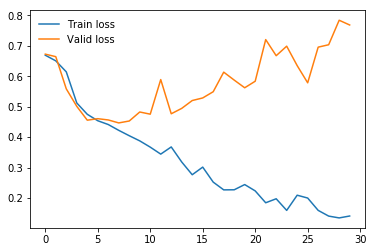

In [24]:
plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)

# Time: 5s per epoch
# Accuracy: 81.8%

In [26]:
ls = glob(MPATH + '*')
ls.sort()
filename = ls[-1]
print(filename)

model = Network(**kw).to(device)

model.load_state_dict(torch.load(filename, map_location=device))

../models/notebook6/commenting/model-08-0.422-0.447-0.809.pt


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [27]:
def predict(sentence):
    tokenized = tokenizer(sentence)
    indexed = [text_field.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    
    print(f'Tokenized: {tokenized}')
    print(f'Indexed: {indexed}')
    print(f'Tensor ({tensor.shape}): {tensor}')
    
    tensor = tensor.unsqueeze(0) # as we have used batch_first=True
    with torch.no_grad():
        model.eval()
        fx = model(tensor)

    print(f'Tensor w/ batch_size ({tensor.shape}): {tensor}')
    print(f'Logit Tensor ({fx.shape}): {fx}')
    return torch.sigmoid(fx).item()

In [28]:
predict("I had prying eyes on me this morning at the bus station")

Tokenized: ['i', 'have', 'pry', 'eye', 'on', 'me', 'this', 'morning', 'at', 'the', 'bus', 'station']
Indexed: [6, 34, 0, 455, 12, 10, 30, 140, 13, 5, 36, 65]
Tensor (torch.Size([12])): tensor([  6,  34,   0, 455,  12,  10,  30, 140,  13,   5,  36,  65],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 12])): tensor([[  6,  34,   0, 455,  12,  10,  30, 140,  13,   5,  36,  65]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-0.1061], device='cuda:2')


0.4735102951526642

In [29]:
predict("I had a stalker this morning at the bus station")

Tokenized: ['i', 'have', 'a', 'stalker', 'this', 'morning', 'at', 'the', 'bus', 'station']
Indexed: [6, 34, 4, 2883, 30, 140, 13, 5, 36, 65]
Tensor (torch.Size([10])): tensor([   6,   34,    4, 2883,   30,  140,   13,    5,   36,   65],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 10])): tensor([[   6,   34,    4, 2883,   30,  140,   13,    5,   36,   65]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.0785], device='cuda:2')


0.25378960371017456

In [30]:
predict("This person followed me at night and tried to sexually harass me")

Tokenized: ['this', 'person', 'follow', 'me', 'at', 'night', 'and', 'try', 'to', 'sexually', 'harass', 'me']
Indexed: [30, 144, 54, 10, 13, 88, 3, 44, 7, 211, 129, 10]
Tensor (torch.Size([12])): tensor([ 30, 144,  54,  10,  13,  88,   3,  44,   7, 211, 129,  10],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 12])): tensor([[ 30, 144,  54,  10,  13,  88,   3,  44,   7, 211, 129,  10]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.4611], device='cuda:2')


0.18829233944416046

In [31]:
predict("There were quite a few people passing lewd remarks at a young lady")

Tokenized: ['there', 'be', 'quite', 'a', 'few', 'people', 'pass', 'lewd', 'remark', 'at', 'a', 'young', 'lady']
Indexed: [38, 2, 437, 4, 121, 85, 49, 292, 491, 13, 4, 209, 130]
Tensor (torch.Size([13])): tensor([ 38,   2, 437,   4, 121,  85,  49, 292, 491,  13,   4, 209, 130],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 13])): tensor([[ 38,   2, 437,   4, 121,  85,  49, 292, 491,  13,   4, 209, 130]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([1.9259], device='cuda:2')


0.8727921843528748

In [32]:
predict("The person grabbed the woman's pubes in the park")

Tokenized: ['the', 'person', 'grab', 'the', 'woman', "'s", 'pubis', 'in', 'the', 'park']
Indexed: [5, 144, 238, 5, 108, 100, 7053, 8, 5, 220]
Tensor (torch.Size([10])): tensor([   5,  144,  238,    5,  108,  100, 7053,    8,    5,  220],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 10])): tensor([[   5,  144,  238,    5,  108,  100, 7053,    8,    5,  220]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.4524], device='cuda:2')


0.18963053822517395

### Groping

In [22]:
EPOCHS = 30
best_valid_acc = 0

train_losses = []
valid_losses = []

for e in range(1, EPOCHS + 1):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, validloader, criterion)

    # model progress
    print(f"Epoch: {e:02}/{EPOCHS}... "
          f"| Train Loss: {train_loss:.4f} "
          f"| Valid Loss: {valid_loss:.4f} "
          f"| Train Acc: {train_acc:.4f} "
          f"| Valid Acc: {valid_acc:.4f}")
    
    if best_valid_acc < valid_acc:
        best_valid_acc = valid_acc

        filename = f'model-{e:02}-{train_loss:.3f}-{valid_loss:.3f}-{valid_acc:.3f}.pt'
#         torch.save(model.state_dict(), MPATH + filename)
        
        best_model.load_state_dict(model.state_dict())
        best_name = filename
    
    # for model complexity graph
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

print('Done\n')
vl, vacc, vprec, vrec, vf1 = evaluate(best_model, validloader, criterion, others=True)
print(f'Valid: Loss {vl:.4f} | Acc {vacc:.4f} | Prec {vprec:.4f} | Rec {vrec:.4f} | F1 {vf1:.4f}')
tl, tacc, tprec, trec, tf1 = evaluate(best_model, testloader, criterion, others=True)
print(f'Test : Loss {tl:.4f} | Acc {tacc:.4f} | Prec {tprec:.4f} | Rec {trec:.4f} | F1 {tf1:.4f}')

Epoch: 01/30... | Train Loss: 0.6393 | Valid Loss: 0.6071 | Train Acc: 0.6992 | Valid Acc: 0.7111
Epoch: 02/30... | Train Loss: 0.6179 | Valid Loss: 0.6042 | Train Acc: 0.6992 | Valid Acc: 0.7111
Epoch: 03/30... | Train Loss: 0.5962 | Valid Loss: 0.5189 | Train Acc: 0.6996 | Valid Acc: 0.7434
Epoch: 04/30... | Train Loss: 0.4965 | Valid Loss: 0.4052 | Train Acc: 0.7877 | Valid Acc: 0.8374
Epoch: 05/30... | Train Loss: 0.3956 | Valid Loss: 0.3734 | Train Acc: 0.8490 | Valid Acc: 0.8535
Epoch: 06/30... | Train Loss: 0.3691 | Valid Loss: 0.3515 | Train Acc: 0.8615 | Valid Acc: 0.8566
Epoch: 07/30... | Train Loss: 0.3435 | Valid Loss: 0.3599 | Train Acc: 0.8742 | Valid Acc: 0.8606
Epoch: 08/30... | Train Loss: 0.3292 | Valid Loss: 0.3594 | Train Acc: 0.8746 | Valid Acc: 0.8626
Epoch: 09/30... | Train Loss: 0.3064 | Valid Loss: 0.3682 | Train Acc: 0.8874 | Valid Acc: 0.8566
Epoch: 10/30... | Train Loss: 0.3079 | Valid Loss: 0.4073 | Train Acc: 0.8879 | Valid Acc: 0.8293
Epoch: 11/30... | Tr

In [23]:
torch.save(best_model.state_dict(), MPATH + best_name)
best_name

'model-19-0.181-0.429-0.871.pt'

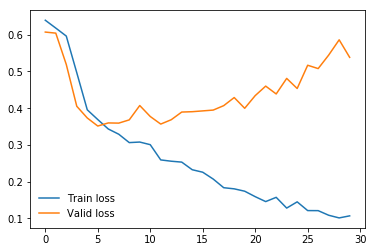

In [24]:
plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)

# Time: 5s per epoch
# Accuracy: 87.60%

In [26]:
ls = glob(MPATH + '*')
ls.sort()
filename = ls[-1]
print(filename)

model = Network(**kw).to(device)

model.load_state_dict(torch.load(filename, map_location=device))

../models/notebook6/groping/model-19-0.181-0.429-0.871.pt


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [27]:
def predict(sentence):
    tokenized = tokenizer(sentence)
    indexed = [text_field.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    
    print(f'Tokenized: {tokenized}')
    print(f'Indexed: {indexed}')
    print(f'Tensor ({tensor.shape}): {tensor}')
    
    tensor = tensor.unsqueeze(0) # as we have used batch_first=True
    with torch.no_grad():
        model.eval()
        fx = model(tensor)

    print(f'Tensor w/ batch_size ({tensor.shape}): {tensor}')
    print(f'Logit Tensor ({fx.shape}): {fx}')
    return torch.sigmoid(fx).item()

In [28]:
predict("I had prying eyes on me this morning at the bus station")

Tokenized: ['i', 'have', 'pry', 'eye', 'on', 'me', 'this', 'morning', 'at', 'the', 'bus', 'station']
Indexed: [6, 34, 0, 455, 12, 10, 30, 140, 13, 5, 36, 65]
Tensor (torch.Size([12])): tensor([  6,  34,   0, 455,  12,  10,  30, 140,  13,   5,  36,  65],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 12])): tensor([[  6,  34,   0, 455,  12,  10,  30, 140,  13,   5,  36,  65]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-4.3627], device='cuda:2')


0.012583277188241482

In [29]:
predict("I had a stalker this morning at the bus station")

Tokenized: ['i', 'have', 'a', 'stalker', 'this', 'morning', 'at', 'the', 'bus', 'station']
Indexed: [6, 34, 4, 2883, 30, 140, 13, 5, 36, 65]
Tensor (torch.Size([10])): tensor([   6,   34,    4, 2883,   30,  140,   13,    5,   36,   65],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 10])): tensor([[   6,   34,    4, 2883,   30,  140,   13,    5,   36,   65]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.2134], device='cuda:2')


0.22909575700759888

In [30]:
predict("This person followed me at night and tried to sexually harass me")

Tokenized: ['this', 'person', 'follow', 'me', 'at', 'night', 'and', 'try', 'to', 'sexually', 'harass', 'me']
Indexed: [30, 144, 54, 10, 13, 88, 3, 44, 7, 211, 129, 10]
Tensor (torch.Size([12])): tensor([ 30, 144,  54,  10,  13,  88,   3,  44,   7, 211, 129,  10],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 12])): tensor([[ 30, 144,  54,  10,  13,  88,   3,  44,   7, 211, 129,  10]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([2.5384], device='cuda:2')


0.9267875552177429

In [31]:
predict("There were quite a few people passing lewd remarks at a young lady")

Tokenized: ['there', 'be', 'quite', 'a', 'few', 'people', 'pass', 'lewd', 'remark', 'at', 'a', 'young', 'lady']
Indexed: [38, 2, 437, 4, 121, 85, 49, 292, 491, 13, 4, 209, 130]
Tensor (torch.Size([13])): tensor([ 38,   2, 437,   4, 121,  85,  49, 292, 491,  13,   4, 209, 130],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 13])): tensor([[ 38,   2, 437,   4, 121,  85,  49, 292, 491,  13,   4, 209, 130]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-5.1673], device='cuda:2')


0.0056678359396755695

In [32]:
predict("The person grabbed the woman's pubes in the park")

Tokenized: ['the', 'person', 'grab', 'the', 'woman', "'s", 'pubis', 'in', 'the', 'park']
Indexed: [5, 144, 238, 5, 108, 100, 7053, 8, 5, 220]
Tensor (torch.Size([10])): tensor([   5,  144,  238,    5,  108,  100, 7053,    8,    5,  220],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 10])): tensor([[   5,  144,  238,    5,  108,  100, 7053,    8,    5,  220]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([3.7533], device='cuda:2')


0.9770959615707397

### Ogling

In [22]:
EPOCHS = 30
best_valid_acc = 0

train_losses = []
valid_losses = []

for e in range(1, EPOCHS + 1):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, validloader, criterion)

    # model progress
    print(f"Epoch: {e:02}/{EPOCHS}... "
          f"| Train Loss: {train_loss:.4f} "
          f"| Valid Loss: {valid_loss:.4f} "
          f"| Train Acc: {train_acc:.4f} "
          f"| Valid Acc: {valid_acc:.4f}")
    
    if best_valid_acc < valid_acc:
        best_valid_acc = valid_acc

        filename = f'model-{e:02}-{train_loss:.3f}-{valid_loss:.3f}-{valid_acc:.3f}.pt'
#         torch.save(model.state_dict(), MPATH + filename)
        
        best_model.load_state_dict(model.state_dict())
        best_name = filename
    
    # for model complexity graph
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

print('Done\n')
vl, vacc, vprec, vrec, vf1 = evaluate(best_model, validloader, criterion, others=True)
print(f'Valid: Loss {vl:.4f} | Acc {vacc:.4f} | Prec {vprec:.4f} | Rec {vrec:.4f} | F1 {vf1:.4f}')
tl, tacc, tprec, trec, tf1 = evaluate(best_model, testloader, criterion, others=True)
print(f'Test : Loss {tl:.4f} | Acc {tacc:.4f} | Prec {tprec:.4f} | Rec {trec:.4f} | F1 {tf1:.4f}')

Epoch: 01/30... | Train Loss: 0.5875 | Valid Loss: 0.5177 | Train Acc: 0.7645 | Valid Acc: 0.7848
Epoch: 02/30... | Train Loss: 0.5234 | Valid Loss: 0.5147 | Train Acc: 0.7881 | Valid Acc: 0.7848
Epoch: 03/30... | Train Loss: 0.5169 | Valid Loss: 0.5048 | Train Acc: 0.7881 | Valid Acc: 0.7848
Epoch: 04/30... | Train Loss: 0.4993 | Valid Loss: 0.4659 | Train Acc: 0.7881 | Valid Acc: 0.7848
Epoch: 05/30... | Train Loss: 0.4702 | Valid Loss: 0.4565 | Train Acc: 0.7939 | Valid Acc: 0.8152
Epoch: 06/30... | Train Loss: 0.4528 | Valid Loss: 0.4441 | Train Acc: 0.8195 | Valid Acc: 0.8283
Epoch: 07/30... | Train Loss: 0.4355 | Valid Loss: 0.4218 | Train Acc: 0.8306 | Valid Acc: 0.8364
Epoch: 08/30... | Train Loss: 0.4192 | Valid Loss: 0.4261 | Train Acc: 0.8368 | Valid Acc: 0.8364
Epoch: 09/30... | Train Loss: 0.4119 | Valid Loss: 0.4228 | Train Acc: 0.8403 | Valid Acc: 0.8202
Epoch: 10/30... | Train Loss: 0.4003 | Valid Loss: 0.4233 | Train Acc: 0.8425 | Valid Acc: 0.8394
Epoch: 11/30... | Tr

In [23]:
torch.save(best_model.state_dict(), MPATH + best_name)
best_name

'model-10-0.400-0.423-0.839.pt'

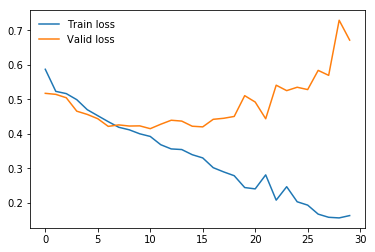

In [24]:
plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)

# Time: 5s per epoch
# Accuracy: 83.42%

In [25]:
ls = glob(MPATH + '*')
ls.sort()
filename = ls[-1]
print(filename)

model = Network(**kw).to(device)

model.load_state_dict(torch.load(filename, map_location=device))

../models/notebook6/ogling/model-10-0.400-0.423-0.839.pt


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [26]:
def predict(sentence):
    tokenized = tokenizer(sentence)
    indexed = [text_field.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    
    print(f'Tokenized: {tokenized}')
    print(f'Indexed: {indexed}')
    print(f'Tensor ({tensor.shape}): {tensor}')
    
    tensor = tensor.unsqueeze(0) # as we have used batch_first=True
    with torch.no_grad():
        model.eval()
        fx = model(tensor)

    print(f'Tensor w/ batch_size ({tensor.shape}): {tensor}')
    print(f'Logit Tensor ({fx.shape}): {fx}')
    return torch.sigmoid(fx).item()

In [34]:
predict("I had prying eyes on me this morning at the bus station")

Tokenized: ['i', 'have', 'pry', 'eye', 'on', 'me', 'this', 'morning', 'at', 'the', 'bus', 'station']
Indexed: [6, 34, 0, 455, 12, 10, 30, 140, 13, 5, 36, 65]
Tensor (torch.Size([12])): tensor([  6,  34,   0, 455,  12,  10,  30, 140,  13,   5,  36,  65],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 12])): tensor([[  6,  34,   0, 455,  12,  10,  30, 140,  13,   5,  36,  65]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-2.3343], device='cuda:2')


0.08831952512264252

In [35]:
predict("I had a stalker this morning at the bus station")

Tokenized: ['i', 'have', 'a', 'stalker', 'this', 'morning', 'at', 'the', 'bus', 'station']
Indexed: [6, 34, 4, 2883, 30, 140, 13, 5, 36, 65]
Tensor (torch.Size([10])): tensor([   6,   34,    4, 2883,   30,  140,   13,    5,   36,   65],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 10])): tensor([[   6,   34,    4, 2883,   30,  140,   13,    5,   36,   65]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-2.6091], device='cuda:2')


0.06855245679616928

In [36]:
predict("This person followed me at night and tried to sexually harass me")

Tokenized: ['this', 'person', 'follow', 'me', 'at', 'night', 'and', 'try', 'to', 'sexually', 'harass', 'me']
Indexed: [30, 144, 54, 10, 13, 88, 3, 44, 7, 211, 129, 10]
Tensor (torch.Size([12])): tensor([ 30, 144,  54,  10,  13,  88,   3,  44,   7, 211, 129,  10],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 12])): tensor([[ 30, 144,  54,  10,  13,  88,   3,  44,   7, 211, 129,  10]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.9367], device='cuda:2')


0.12601372599601746

In [37]:
predict("There were quite a few people passing lewd remarks at a young lady")

Tokenized: ['there', 'be', 'quite', 'a', 'few', 'people', 'pass', 'lewd', 'remark', 'at', 'a', 'young', 'lady']
Indexed: [38, 2, 437, 4, 121, 85, 49, 292, 491, 13, 4, 209, 130]
Tensor (torch.Size([13])): tensor([ 38,   2, 437,   4, 121,  85,  49, 292, 491,  13,   4, 209, 130],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 13])): tensor([[ 38,   2, 437,   4, 121,  85,  49, 292, 491,  13,   4, 209, 130]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.9894], device='cuda:2')


0.12032529711723328

In [38]:
predict("The person grabbed the woman's pubes in the park")

Tokenized: ['the', 'person', 'grab', 'the', 'woman', "'s", 'pubis', 'in', 'the', 'park']
Indexed: [5, 144, 238, 5, 108, 100, 7053, 8, 5, 220]
Tensor (torch.Size([10])): tensor([   5,  144,  238,    5,  108,  100, 7053,    8,    5,  220],
       device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 10])): tensor([[   5,  144,  238,    5,  108,  100, 7053,    8,    5,  220]],
       device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-2.8253], device='cuda:2')


0.05597180873155594